In [21]:
import pandas as pd
import gzip
import numpy as np
from datetime import datetime, timedelta
from tqdm import tqdm
import random
import numpy as np

In [22]:
# LOCAL = 'Avenches'
LOCAL = 'New York'
FRACT_ACT = 1
FRACT_POP = 1
TIME_INTERVAL = 5 # ou 10
activity_types = ['Secondary', 'Work', 'Education']
HORIZON = round(24*60/TIME_INTERVAL) + 1
tqdm.pandas()

#### Generic functions :

In [23]:
def stratified_sample(df, column, fraction):
    """
    Perform stratified sampling on df based on column.
    :param df: Input dataframe
    :param column: Column name for stratification
    :param fraction: Fraction of rows to sample from each group
    :return: Sampled dataframe
    """
    return df.groupby(column).apply(lambda x: x.sample(frac=fraction)).reset_index(drop=True)

In [ ]:
def round_to_horizon(t):
    """ Help to round a time to 5m intervals """
    # Convert datetime.time to datetime.datetime for calculations
    dt = datetime.combine(datetime.today(), t)
    
    # Find the number of seconds since midnight
    seconds_since_midnight = (dt - dt.replace(hour=0, minute=0, second=0, microsecond=0)).seconds

    # Round to the closest 5 minutes (300 seconds)
    rounded_seconds = round(seconds_since_midnight / (TIME_INTERVAL*60)) * TIME_INTERVAL*60
    rounded_dt = dt.replace(hour=0, minute=0, second=0) + timedelta(seconds=rounded_seconds)

    return rounded_dt.time()

def time_to_horizon_interval(t):
    """ Return time horizon corresponding to a timestamp """
    rounded_time = round_to_horizon(t)
    
    # Convert datetime.time to datetime.datetime for calculations
    dt = datetime.combine(datetime.today(), rounded_time)
    
    # Get total minutes since midnight
    minutes_since_midnight = (dt - dt.replace(hour=0, minute=0, second=0)).seconds // 60

    # Convert total minutes to horizon intervals (5 minute intervals)
    horizon_interval = minutes_since_midnight // TIME_INTERVAL

    return horizon_interval

#### Preprocessing

Read the data and filter the irrelevants columns

In [24]:
activity_file = '/Users/cloe/Documents/GitHub/data_abm/Data/1_Original/nyc_activities.csv.gz'
population_file = '/Users/cloe/Documents/GitHub/data_abm/Data/1_Original/nyc_population.csv.gz'
trip_file = '/Users/cloe/Documents/GitHub/data_abm/Data/1_Original/nyc_trips.csv.gz'

def read_gzipped_csv(file_path):
    with gzip.open(file_path, 'rt') as file:
        df = pd.read_csv(file)
    return df

activity_vaud = read_gzipped_csv(activity_file)[['id', 'type', 'x', 'y', 'start_time', 'end_time','facility']]
population_vaud = read_gzipped_csv(population_file)[['id', 'age','gender', 'employed','higher_education', 'home_x', 'home_y']]

In [25]:
# act=pd.read_csv('/Users/cloe/Downloads/C2SMART-Year3-Project/input/nyc_activities.csv.gz')
# act[act['person_id']==1257522]

In [26]:
# activity_vaud[activity_vaud['id']==1257522]

In [27]:
# act_pre=pd.read_csv('/Users/cloe/Documents/GitHub/data_abm/Data/2_PreProcessed/activities_NewYork.csv')
# act_pre[act_pre['id']==1257522]

In [28]:
# pop_pre=pd.read_csv('/Users/cloe/Documents/GitHub/data_abm/Data/2_PreProcessed/population_NewYork.csv')
# pop_pre[pop_pre['id']==1257522]

In [29]:
from datetime import timedelta

# Assume df is your DataFrame

# First, ensure the 'start_time' and 'end_time' are in the correct time format
activity_vaud['start_time'] = pd.to_datetime(activity_vaud['start_time'], format='%H:%M:%S', errors='coerce').dt.time
activity_vaud['end_time'] = pd.to_datetime(activity_vaud['end_time'], format='%H:%M:%S', errors='coerce').dt.time

# Function to apply the necessary changes for each group
def process_individual(group):
    # Check if the first row has NaN in 'start_time'
    if pd.isna(group.iloc[0]['start_time']):
        group.at[group.index[0], 'start_time'] = pd.to_datetime('00:00:00').time()
    
    # Ensure the second to last end_time is not NaT before proceeding with last row adjustments
    if not pd.isna(group.iloc[-2]['end_time']):
        last_end_time = group.iloc[-2]['end_time']
        # Calculate and set the start_time and end_time for the last row if needed
        if pd.isna(group.iloc[-1]['start_time']) or pd.isna(group.iloc[-1]['end_time']):
            calculated_start_time = (pd.Timestamp(last_end_time.strftime('%H:%M:%S')) + timedelta(minutes=10)).time()
            group.at[group.index[-1], 'start_time'] = calculated_start_time
            group.at[group.index[-1], 'end_time'] = pd.to_datetime('23:59:00').time()
    
    return group

# Apply the function to each group and recombine them into a single DataFrame
activity_vaud = activity_vaud.groupby('id').apply(process_individual)


KeyboardInterrupt: 

In [ ]:
activity_vaud.to_csv('/Users/cloe/Documents/GitHub/data_abm/Data/1_Original/nyc_activities.csv.gz')

In [30]:
activity_vaud=pd.read_csv('/Users/cloe/Documents/GitHub/data_abm/Data/1_Original/nyc_activities.csv.gz')

Filter the population by the city

In [31]:
population_local = population_vaud
# print(len(population_local))
# population_local.head(1)

Use the filtered population to extract activities of the same city. Also count the activities by type in this city. 

In [32]:
population_local_ids = population_local['id'].unique()
activity_local = activity_vaud[activity_vaud['id'].isin(population_local_ids)]
print(f"Original DataFrame size: {activity_local.shape}")
# Find IDs with any NaT in 'start_time' or 'end_time'
ids_with_nat = activity_local[activity_local['start_time'].isna() | activity_local['end_time'].isna()]['id'].unique()
# Filter out these IDs from the DataFrame
activity_local= activity_local[~activity_local['id'].isin(ids_with_nat)]
print(f"Cleaned DataFrame size: {activity_local.shape}")
activity_local['type'] = activity_local['type'].replace('University', 'Education')
activity_local['type'] = activity_local['type'].replace('School', 'Education')
activity_local_filt_nowork = activity_local[~activity_local['type'].isin([ 'Home'])] 

count_act_by_types = activity_local_filt_nowork.groupby('type')['facility'].nunique().reset_index()
print(f"Here's the count of facilities by types in {LOCAL} : {count_act_by_types}")
# print(len(activity_local_filt))

Original DataFrame size: (1417621, 9)
Cleaned DataFrame size: (1406838, 9)
Here's the count of facilities by types in New York :         type  facility
0  Education     51640
1  Secondary    286611
2       Work     93044


Sample the activities of this city by keeping the proportion between each type (stratified sampling)

In [33]:
# peut etre associer un seed pour avoir toujours le meme resultat ? 
# Attention : stratified sampling != proportional sampling 
activity_local_filt_sampled_s = stratified_sample(activity_local_filt_nowork, column='type', fraction=FRACT_ACT) # 0.001 to compare exact / heuristic
# activity_local_filt_sampled.drop(columns=['start_time', 'end_time'], inplace=True)
# print(len(activity_local_filt_sampled))
# count_act_by_types_sampled = activity_local_filt_sampled.groupby('type')['facility'].nunique().reset_index()
# print(f"Here's the count of facilities by types in the sample : {count_act_by_types_sampled}")
activity_local_filt_sampled_s.head()

,id,Unnamed: 1,id.1,type,x,y,start_time,end_time,facility
0,7553014,1295736,7553014,Education,9.982325e+05,173063.182811,07:50:00,14:25:00,637544
1,6561833,1124866,6561833,Education,9.948138e+05,217870.767027,08:00:00,13:50:00,558751
2,1350557,250149,1350557,Education,1.000956e+06,226079.377461,08:30:00,16:00:00,130374
3,1215959,227717,1215959,Education,1.003520e+06,252938.710590,08:11:00,15:00:00,119175
4,2200874,392582,2200874,Education,1.016118e+06,212501.274893,07:45:00,14:45:00,198870


Create new columns for each activity with their caracterics (anticipate initialization)

In [34]:
# 0 = 00:00 // 288 = 24:00 (total len = 289)
# Code to fix the following values for each activity type : 
    # t1 = earliest time to start
    # t2 = latest time to start
    # t3 = max duration
    # min duration
    # des duration
for i, row in activity_local_filt_sampled_s.iterrows():
    type_ = row['type']
    match type_: # need python >=3.10
        case 'Education':
            activity_local_filt_sampled_s.at[i, 'group'] = 1
            activity_local_filt_sampled_s.at[i, 'earliest_start'] = 7*60/TIME_INTERVAL # 7h
            activity_local_filt_sampled_s.at[i, 'latest_start'] = 23*60/TIME_INTERVAL # 23h
            activity_local_filt_sampled_s.at[i, 'max_duration'] = 10*60/TIME_INTERVAL # 10h
            activity_local_filt_sampled_s.at[i, 'min_duration'] = 10/TIME_INTERVAL # 10m
        case 'Secondary':
            activity_local_filt_sampled_s.at[i, 'group'] = 3
            activity_local_filt_sampled_s.at[i, 'earliest_start'] = 7*60/TIME_INTERVAL # 7h
            activity_local_filt_sampled_s.at[i, 'latest_start'] = 23*60/TIME_INTERVAL # 23h
            activity_local_filt_sampled_s.at[i, 'max_duration'] = 10*60/TIME_INTERVAL # 10h
            activity_local_filt_sampled_s.at[i, 'min_duration'] = 10/TIME_INTERVAL # 10m
        case 'Work':
            activity_local_filt_sampled_s.at[i, 'group'] = 2
            activity_local_filt_sampled_s.at[i, 'earliest_start'] = 5*60/TIME_INTERVAL # 7h
            activity_local_filt_sampled_s.at[i, 'latest_start'] = 23*60/TIME_INTERVAL # 23h
            activity_local_filt_sampled_s.at[i, 'max_duration'] = 12*60/TIME_INTERVAL # 10h
            activity_local_filt_sampled_s.at[i, 'min_duration'] = 10/TIME_INTERVAL # 10m
    # # work
    # activities_array[num_activities-3].id = num_activities-3
    # activities_array[num_activities-3].x = individual['work_x']
    # activities_array[num_activities-3].y = individual['work_y']
    # activities_array[num_activities-3].earliest_start = round(5*60/TIME_INTERVAL) # 5h
    # activities_array[num_activities-3].latest_start = round(23*60/TIME_INTERVAL) # 23h
    # activities_array[num_activities-3].max_duration = round(12*60/TIME_INTERVAL) # 12h
    # activities_array[num_activities-3].min_duration = round(10/TIME_INTERVAL) # 10m
    # activities_array[num_activities-3].group = 2
    # activities_array[num_activities-3].des_duration = individual['work_dur']
    # activities_array[num_activities-3].des_start_time = individual['work_start']
            
print(activity_local_filt_sampled_s)

             id  Unnamed: 1     id.1       type             x              y  \
0       7553014     1295736  7553014  Education  9.982325e+05  173063.182811   
1       6561833     1124866  6561833  Education  9.948138e+05  217870.767027   
2       1350557      250149  1350557  Education  1.000956e+06  226079.377461   
3       1215959      227717  1215959  Education  1.003520e+06  252938.710590   
4       2200874      392582  2200874  Education  1.016118e+06  212501.274893   
...         ...         ...      ...        ...           ...            ...   
674335  2879264      508437  2879264       Work  1.047243e+06  187885.544531   
674336   533438      102036   533438       Work  9.881166e+05  206745.713796   
674337  3049480      536399  3049480       Work  9.806051e+05  196154.950800   
674338   606904      114045   606904       Work  9.895910e+05  210502.252926   
674339  4075766      707426  4075766       Work  9.940674e+05  230658.576666   

       start_time  end_time  facility  

Sample the individuals among the city inhabitants and converts home coordinates in `int`

In [35]:
# int_columns = ['earliest_start', 'latest_start', 'max_duration', 'min_duration', 'x', 'y', 'group']
# activity_local_filt_sampled[int_columns] = activity_local_filt_sampled[int_columns].astype(int) 
# # Proof that we have a activity id : 
# # print(len(activity_local_filt_sampled))
# print(activity_local_filt_sampled.index.nunique())
# activity_local_filt_sampled

In [36]:
population_local_sample = population_local.sample(frac = FRACT_POP)
# print(len(population_local))
# print(len(population_local_sample))
population_local_sample.head(6)
# activity_local_filt_sampled.head()

,id,age,gender,employed,higher_education,home_x,home_y
113780,606845,45-49,0.0,1.0,17.0,9.902608e+05,212714.998352
1294433,7548814,70-74,0.0,0.0,17.0,1.007276e+06,177176.402630
128161,677317,25-29,0.0,0.0,17.0,9.868863e+05,220807.322483
733602,4233219,22-24,0.0,1.0,17.0,1.005981e+06,240570.432897
645891,3705955,30-34,0.0,1.0,17.0,1.056001e+06,199621.987494
1105716,6427165,70-74,0.0,0.0,17.0,1.001411e+06,179071.159668


Filter invalid times (hours < 24) & Convert time object in terms of horizons  

In [37]:
import pandas as pd
import datetime
activity_local_filt_sampled=activity_local_filt_sampled_s
# Helper function to convert time to a horizon interval
def time_to_horizon_interval(t):
    # Assuming each interval is 15 minutes, for example
    if t == datetime.time(23, 59):  # Handle 23:59 as a special case
        return 288  # If the day is divided into 96 intervals of 15 minutes each
    total_minutes = t.hour * 60 + t.minute
    return total_minutes // 5  # Returns the interval index

# Assuming 'start_time' and 'end_time' are already in the correct format ('HH:MM')
activity_local_filt_sampled['start_time'] = pd.to_timedelta(activity_local_filt_sampled['start_time'].astype(str))
activity_local_filt_sampled['end_time'] = pd.to_timedelta(activity_local_filt_sampled['end_time'].astype(str))

# Ensure times are less than 24 hours and not NaT
activity_local_filt_sampled = activity_local_filt_sampled[
    (activity_local_filt_sampled['start_time'] < pd.Timedelta('1 days')) &
    (activity_local_filt_sampled['end_time'] < pd.Timedelta('1 days'))
]

# Convert 'start_time' and 'end_time' to datetime.time
activity_local_filt_sampled['start_time'] = activity_local_filt_sampled['start_time'].apply(
    lambda x: (datetime.datetime.min + x).time() if pd.notnull(x) else None
)
activity_local_filt_sampled['end_time'] = activity_local_filt_sampled['end_time'].apply(
    lambda x: (datetime.datetime.min + x).time() if pd.notnull(x) else None
)

# Apply the interval conversion
activity_local_filt_sampled['start_time_interval'] = activity_local_filt_sampled['start_time'].apply(time_to_horizon_interval)
activity_local_filt_sampled['end_time_interval'] = activity_local_filt_sampled['end_time'].apply(time_to_horizon_interval)

# Calculate the duration interval by subtracting the start interval from the end interval
activity_local_filt_sampled['duration_interval'] = activity_local_filt_sampled['end_time_interval'] - activity_local_filt_sampled['start_time_interval']

# Correct for cases where duration might wrap due to start time being after end time in cyclic schedules
activity_local_filt_sampled['duration_interval'] = activity_local_filt_sampled['duration_interval'].apply(
    lambda x: x if x >= 0 else 288 + x  # Assuming 96 intervals per day, adjust if your day is divided differently
)

# Preview the data
#print(activity_local_filt_sampled.head(30))
print(activity_local_filt_sampled[activity_local_filt_sampled['start_time_interval'] < 62])

             id  Unnamed: 1     id.1       type              x              y  \
240     6191667     1062001  6191667  Education  982625.904227  176778.634468   
263     8188932     1406605  8188932  Education  926993.130207  133130.492156   
293     8146136     1398211  8146136  Education  926270.430959  136420.231797   
336      889318      167293   889318  Education  982008.714467  200047.284940   
851     1203455      225827  1203455  Education  982249.588493  199731.025055   
...         ...         ...      ...        ...            ...            ...   
674152  7050655     1208203  7050655       Work  993913.165572  164479.729562   
674213  2797039      494545  2797039       Work  986510.941155  209262.313683   
674279  2469125      437973  2469125       Work  978390.993768  203848.084907   
674293  4568949      788059  4568949       Work  987190.020708  189623.154854   
674305  1068617      202189  1068617       Work  997363.708425  221517.165918   

       start_time  end_time

For each individual, and for each activity type, add starting time and duration preferences

In [38]:
# Define the age ranges as categories directly corresponding to the strings in your DataFrame
age_categories = {
    '0-20': ['0-4', '5-9', '10-14', '15-17', '18-19', '20'],
    '21-40': ['21', '22-24', '25-29', '30-34', '35-39'],
    '41-65': ['40-44', '45-49', '50-54', '55-59', '60-61', '62-64', '65-66'],
    '66-100': ['67-69', '70-74', '75-79', '80-84', '85+']
}

# Function to map each age category string to a broader category
def map_age_category(age_str):
    for key, age_list in age_categories.items():
        if age_str in age_list:
            return key
    return None  # for NaN or any undefined age group

# Apply this function to create a new column for broad age categories
population_local['age_category'] = population_local['age'].apply(map_age_category)
population_local_sample['age_category'] = population_local_sample['age'].apply(map_age_category)
# Ensure 'employed' column is boolean
population_local['employed'] = population_local['employed'].astype(int).astype(bool)
population_local_sample['employed'] = population_local_sample['employed'].astype(int).astype(bool)

In [39]:
# Filter to find entries in the '0-20' age category
filtered_population = population_local[population_local['age_category'] == '0-20']

# Extract unique IDs from this filtered population
unique_ids = filtered_population['id'].unique()
# Filter the second DataFrame to include only rows where the 'id' is in the list of unique IDs
subset_activity = activity_local_filt_sampled[activity_local_filt_sampled['id'].isin(unique_ids)]
# Display the filtered DataFrame
print(subset_activity)
count_earliest_start_below_80 = subset_activity[subset_activity['earliest_start'] < 62].shape[0]
print(f"Number of entries with 'earliest_start' lower than 80: {count_earliest_start_below_80}")


             id  Unnamed: 1     id.1       type             x              y  \
0       7553014     1295736  7553014  Education  9.982325e+05  173063.182811   
1       6561833     1124866  6561833  Education  9.948138e+05  217870.767027   
2       1350557      250149  1350557  Education  1.000956e+06  226079.377461   
3       1215959      227717  1215959  Education  1.003520e+06  252938.710590   
4       2200874      392582  2200874  Education  1.016118e+06  212501.274893   
...         ...         ...      ...        ...           ...            ...   
674013  3825005      667753  3825005       Work  1.029681e+06  196979.750362   
674014  5450987      935742  5450987       Work  9.972851e+05  198278.212546   
674140  1823573      329150  1823573       Work  1.063671e+06  212648.915900   
674214  5354380      921032  5354380       Work  9.979569e+05  198171.833649   
674330  3781045      659839  3781045       Work  1.054479e+06  184258.802670   

       start_time  end_time  facility  

In [40]:
# Creating sub-populations based on age category and employment status
id_range1 = population_local[population_local['age_category'] == '0-20']
id_range2_emp = population_local[(population_local['age_category'] == '21-40') & (population_local['employed'])]
id_range3_emp = population_local[(population_local['age_category'] == '41-65') & (population_local['employed'])]
id_range4_emp = population_local[(population_local['age_category'] == '66-100') & (population_local['employed'])]
id_range2_unemp = population_local[(population_local['age_category'] == '21-40') & (~population_local['employed'])]
id_range3_unemp = population_local[(population_local['age_category'] == '41-65') & (~population_local['employed'])]
id_range4_unemp = population_local[(population_local['age_category'] == '66-100') & (~population_local['employed'])]

In [41]:
def calculate_distributions(sub_population, activity_local_filt):
    '''Fonction pour calculer la distribution des intervalles de temps de début et de durée
    Returns a dictionary distributions['start_time_interval'] = count // distributions['duration_interval'] = count'''
    distributions = {}
    sub_population_ids = sub_population['id'].unique()
    filtered_activities = activity_local_filt[activity_local_filt['id'].isin(sub_population_ids)]

    for activity_type in filtered_activities['type'].unique():
        activity_data = filtered_activities[filtered_activities['type'] == activity_type]
        start_dist = activity_data['start_time_interval'].value_counts(normalize=True)
        duration_dist = activity_data['duration_interval'].value_counts(normalize=True)
        distributions[activity_type] = {'start': start_dist, 'duration': duration_dist}
    
    return distributions

def get_subpopulation_id(person):
    age_category, employed = person['age_category'], person['employed']
    if age_category == '0-20':
        return 'range1'
    elif age_category == '21-40':
        return 'range2_emp' if employed else 'range2_unemp'
    elif age_category == '41-65':
        return 'range3_emp' if employed else 'range3_unemp'
    else:
        return 'range4_emp' if employed else 'range4_unemp'


# Calculer les distributions pour chaque sous-population
distributions = {
    'range1': calculate_distributions(id_range1, activity_local_filt_sampled),
    'range2_emp': calculate_distributions(id_range2_emp, activity_local_filt_sampled),
    'range3_emp': calculate_distributions(id_range3_emp, activity_local_filt_sampled),
    'range4_emp': calculate_distributions(id_range4_emp, activity_local_filt_sampled),
    'range2_unemp': calculate_distributions(id_range2_unemp, activity_local_filt_sampled),
    'range3_unemp': calculate_distributions(id_range3_unemp, activity_local_filt_sampled),
    'range4_unemp': calculate_distributions(id_range4_unemp, activity_local_filt_sampled),
}
# print(distributions['range2_emp'])

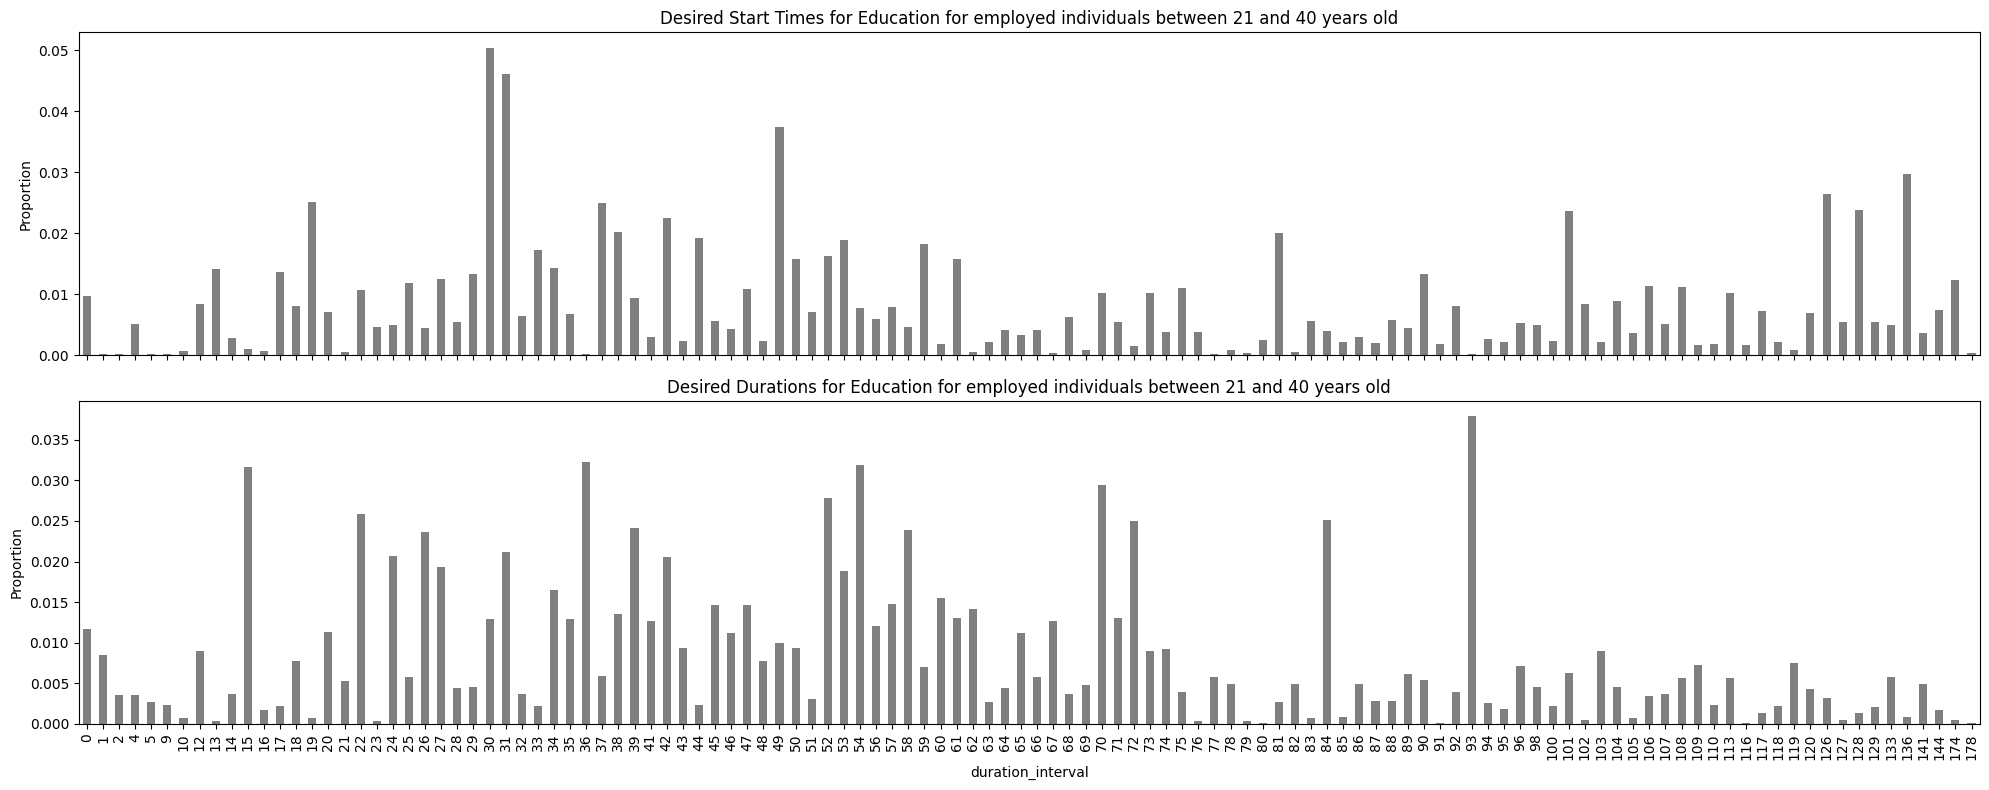

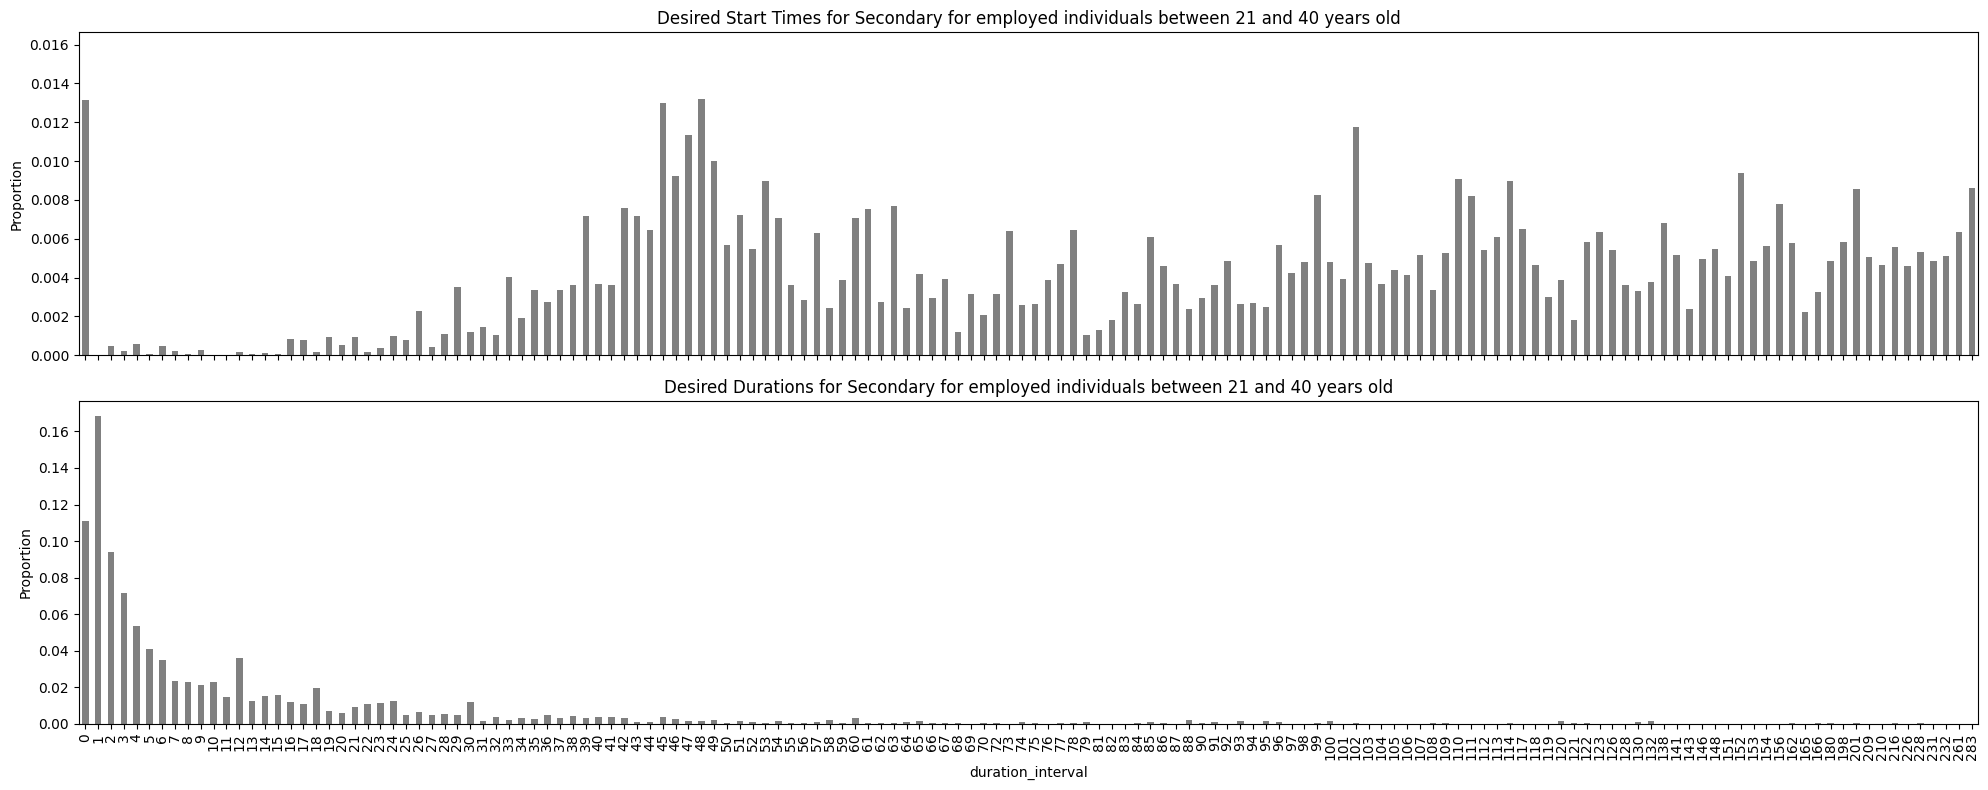

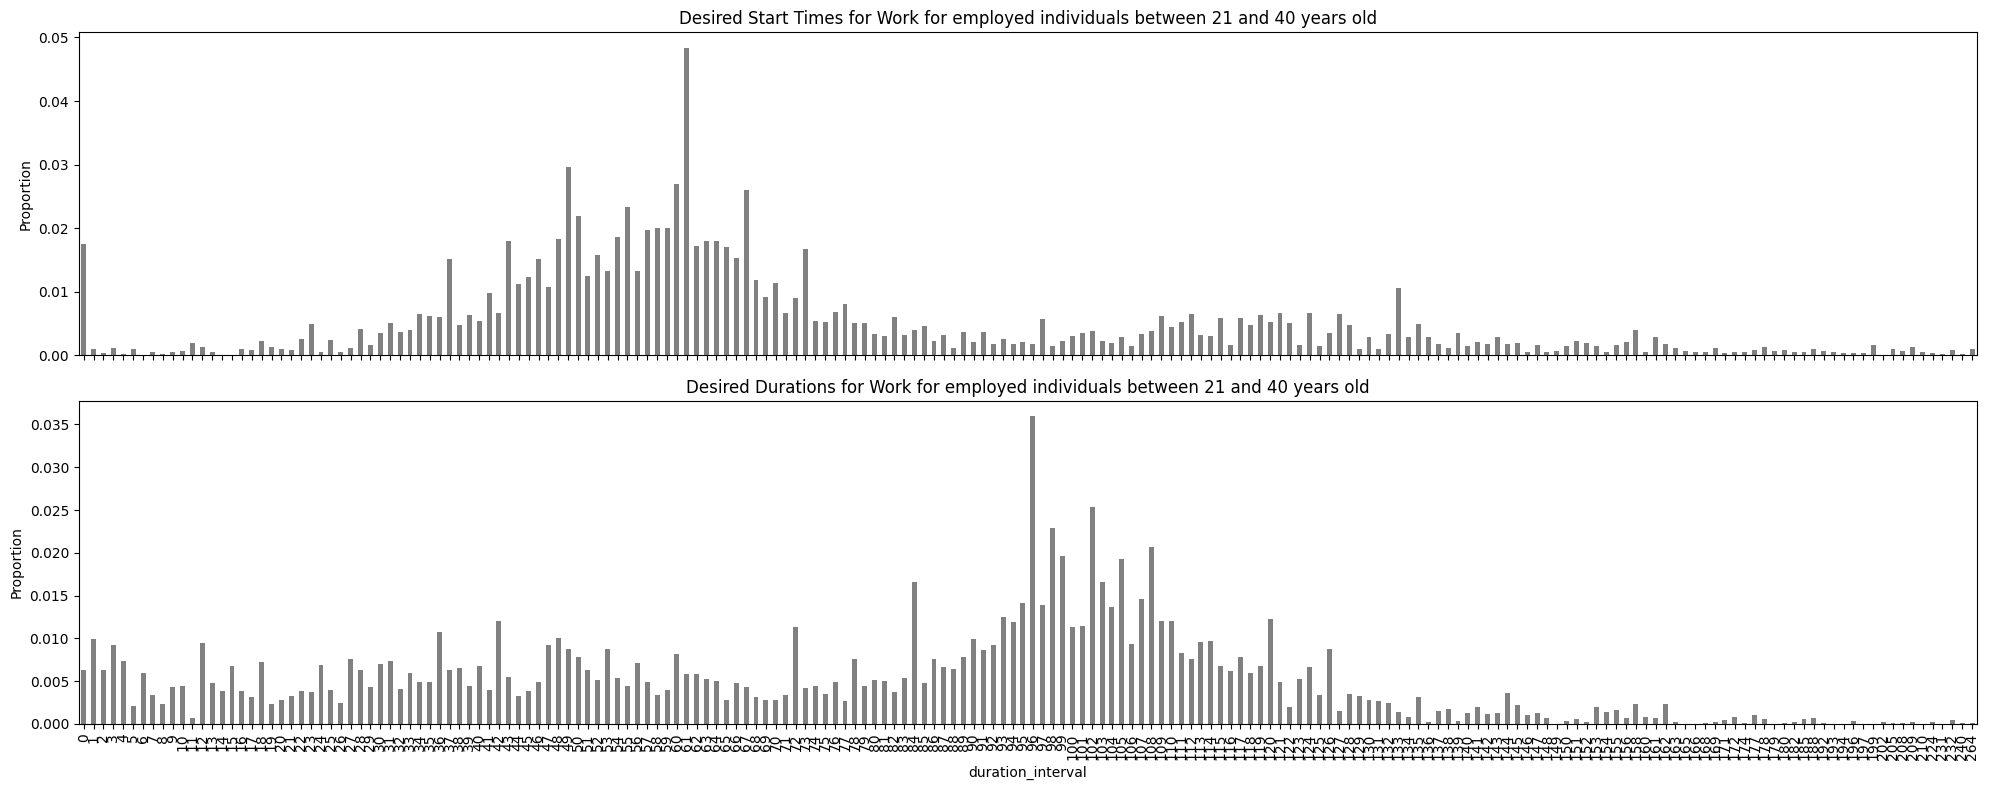

In [47]:
import matplotlib.pyplot as plt

# Function to plot data
def plot_activity_data(activity_data, title):
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 8), sharex=True)
    
    # Start times
    start_series = pd.Series(activity_data['start'])
    start_series.sort_index().plot(kind='bar', ax=axs[0], color='gray')
    axs[0].set_title(f'Desired Start Times for {title}')
    axs[0].set_ylabel('Proportion')
    
    # Durations
    duration_series = pd.Series(activity_data['duration'])
    duration_series.sort_index().plot(kind='bar', ax=axs[1], color='gray')
    axs[1].set_title(f'Desired Durations for {title}')
    axs[1].set_ylabel('Proportion')
    
    plt.tight_layout()
    plt.savefig('/Users/cloe/Desktop/test/figures/distributions.png',dpi=300)

# # Iterate over ranges and activity types
# for range_key, activities in distributions.items():
#     for activity_key, activity_data in activities.items():
#         plot_activity_data(activity_data, f"{activity_key} ({range_key})")

# Specify the key for the range you want to plot
key_to_plot = 'range2_emp'

# Get the data for the specified key from the distributions dictionary
activity_data_to_plot = distributions[key_to_plot]

# Iterate over activity types within the specified range
for activity_key, activity_data in activity_data_to_plot.items():
    plot_activity_data(activity_data, f"{activity_key} for employed individuals between 21 and 40 years old")


In [ ]:
# Filter to get only rows where type is 'Home'
home_ids = set(activity_local[activity_local['type'] == 'Home']['id'].unique())
# Filter the activity DataFrame to keep only rows with IDs that have a 'Home' type
activity_local = activity_local[activity_local['id'].isin(home_ids)]
# Assuming 'population_local_sample' is your population DataFrame and has an 'id' column
population_local_sample = population_local_sample[population_local_sample['id'].isin(home_ids)]


In [ ]:
activity_local_filt_sampled['id'] = activity_local_filt_sampled['id'].astype(int)
population_local_sample['id'] = population_local_sample['id'].astype(int)
# This keeps only those IDs in population_local_sample that are also in activity_local_filt_sampled
population_local_sample = population_local_sample[population_local_sample['id'].isin(activity_local_filt_sampled['id'])]

print("Filtered Unique IDs in population_local_sample:", population_local_sample['id'].nunique())
print("Unique IDs in activity_local_filt_sampled:", activity_local_filt_sampled['id'].nunique())

# Optionally check for any discrepancies
if set(activity_local_filt_sampled['id'].unique()) == set(population_local_sample['id'].unique()):
    print("IDs are consistent between the two DataFrames.")
else:
    print("Warning: There are still discrepancies between the IDs in the two DataFrames.")

In [ ]:
# Get the set of unique IDs from the population DataFrame
valid_ids = set(population_local_sample['id'].unique())

# Filter the activity DataFrame to only include rows with IDs that exist in the population DataFrame
activity_local_filt_sampled = activity_local_filt_sampled[activity_local_filt_sampled['id'].isin(valid_ids)]

# Verify that the filtering was successful
print("Updated Unique IDs in activity_local_filt_sampled:", activity_local_filt_sampled['id'].nunique())
print("Unique IDs in population_local_sample:", population_local_sample['id'].nunique())

# Optionally check for any discrepancies again
if set(activity_local_filt_sampled['id'].unique()) == set(population_local_sample['id'].unique()):
    print("IDs are now perfectly matched between the two DataFrames.")
else:
    print("There are still discrepancies between the IDs in the two DataFrames.")


In [ ]:
# # ARE THERE HOMELESS PEOPLE ? NO
# # get id of pop
# all = activity_vaud['id']
# # get id of pop with a home
# homers = activity_vaud[activity_vaud['type']=='home']['id']
# # difference between the two : people who have no homes
# print(set(all) - set(homers))

activity_local_homes = activity_local[activity_local['type']=='Home']
def get_home_id(row):
    homeid = activity_local_homes[activity_local_homes['id']==row['id']]['facility'].iloc[0]
    if homeid is None: 
        print(f"HOMEID IS NULL {homeid}")
    return homeid
    
population_local_sample.loc[:, 'homeid'] = population_local_sample.progress_apply(lambda row: get_home_id(row), axis=1)
population_local_sample.head()

In [ ]:
# NEW

column_names = [(f'{activity_type}_start', f'{activity_type}_dur') for activity_type in activity_types]

for col_start, col_dur in column_names:
    population_local_sample[col_start] = 0
    population_local_sample[col_dur] = 0

def assign_activity_values(row):
    subpop_id = get_subpopulation_id(row)
    
    for activity_type, (col_start, col_dur) in zip(activity_types, column_names):
        dist = distributions[subpop_id].get(activity_type, {'start': pd.Series(), 'duration': pd.Series()})
        
        if dist['start'].empty or dist['duration'].empty or (subpop_id == 'range1' and activity_type == 'Work'):
            chosen_start = 0
            chosen_duration = 0
        else:
            chosen_start = np.random.choice(dist['start'].index, p=dist['start'].values)
            chosen_duration = np.random.choice(dist['duration'].index, p=dist['duration'].values)
        
        row[col_start] = chosen_start
        row[col_dur] = chosen_duration
    return row

population_local_sample = population_local_sample.progress_apply(assign_activity_values, axis=1)

In [ ]:
population_local_sample

Pick a random work facility for each individual according to the workplace distribution

In [ ]:
df_work_facilities = activity_local[activity_local['type'] == 'Work']
print(f"There are {df_work_facilities['facility'].nunique()} work facilities in {LOCAL}")
work_facilities_count = df_work_facilities.groupby('facility')['id'].count()

# Créer un DataFrame résumé avec les coordonnées moyennes pour chaque établissement
facility_coords = df_work_facilities.groupby('facility')[['x', 'y']].mean()

# Créer le dictionnaire pour les coordonnées x et y des établissements
facility_coords_dict = facility_coords.to_dict('index')

# Choisir un établissement pour chaque individu dans l'échantillon
N = len(population_local_sample)
facilities = work_facilities_count.index.tolist()
workers = work_facilities_count.tolist()
chosen_facilities = random.choices(facilities, weights=workers, k=N)

# Assigner les coordonnées x, y et l'ID de l'établissement choisi
population_local_sample['work_id'] = chosen_facilities
population_local_sample['work_x'] = [facility_coords_dict[facility]['x'] for facility in chosen_facilities]
population_local_sample['work_y'] = [facility_coords_dict[facility]['y'] for facility in chosen_facilities]
population_local_sample.head()

Write the final preprocessed dataframes into .csv files

In [ ]:
population_local_sample

In [ ]:
population_local_sample.columns

In [ ]:
int_columns_2 = [ 'home_x', 'home_y', 'homeid', 'Secondary_start',
       'Secondary_dur', 'Work_start', 'Work_dur', 'Education_start',
       'Education_dur', 'work_id', 'work_x', 'work_y'] 
population_local_sample[int_columns_2] = population_local_sample[int_columns_2].astype(int) 

In [ ]:
population_local_f=population_local_sample[['id', 'age', 'gender','employed', 'higher_education', 'home_x', 'home_y',
        'Secondary_start', 'Secondary_dur',
       'Work_start', 'Work_dur','Education_start', 'Education_dur', 'work_id',
       'work_x', 'work_y','homeid']]

In [ ]:
col = ['x', 'y', 'facility', 'group',
       'earliest_start', 'latest_start', 'max_duration', 'min_duration',
       'start_time_interval', 'end_time_interval', 'duration_interval']

activity_local_filt_sampled[col] = activity_local_filt_sampled[col].astype(int) 

In [ ]:
#activity_local_filt_sampled.drop(['start_time', 'end_time'], axis=1, inplace=True)
activity_local_filt_sampled.to_csv(f'/Users/cloe/Documents/GitHub/data_abm/Data/2_PreProcessed/activities_NewYork.csv', index=False)
population_local_f.to_csv(f'/Users/cloe/Documents/GitHub/data_abm/Data/2_PreProcessed/population_NewYork.csv', index=False) 

In [ ]:
len(population_local_f['id'].unique())

## Risk latent variable

In [4]:
activity_file=pd.read_csv('/Users/cloe/Documents/GitHub/data_abm/Data/2_PreProcessed/activities_NewYork.csv')
population_file=pd.read_csv('/Users/cloe/Documents/GitHub/data_abm/Data/2_PreProcessed/population_NewYork.csv')
population_file

,id,age,gender,employed,higher_education,home_x,home_y,Secondary_start,Secondary_dur,Work_start,Work_dur,Education_start,Education_dur,work_id,work_x,work_y,homeid
0,5423803,40-44,0.0,False,17.0,999875,197404,186,0,132,46,118,46,123131,982122,206105,466221
1,6396469,80-84,1.0,False,17.0,998148,181317,150,3,87,96,151,88,215279,1011470,193103,545703
2,7199312,45-49,1.0,False,17.0,1000871,156605,208,16,113,67,92,78,40452,989247,216356,610130
3,6623002,85+,0.0,False,17.0,984635,156479,198,16,165,99,153,44,253813,1058149,221117,564857
4,1823525,50-54,1.0,True,17.0,1004466,214938,121,50,132,67,120,72,611732,990943,204612,170176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399240,7422661,50-54,1.0,True,17.0,997975,176848,145,3,94,98,102,93,294497,1016515,257342,627087
1399241,7215379,40-44,0.0,True,17.0,999721,155155,232,33,105,93,197,52,70901,983148,213779,611171
1399242,5049638,45-49,1.0,False,17.0,1020028,252077,106,0,148,95,221,88,341036,1049724,154769,437497
1399243,6079912,85+,0.0,True,17.0,989202,183114,140,18,219,1,126,47,8909,989292,211735,519407


In [5]:
survey_df=pd.read_csv('/Users/cloe/Documents/GitHub/latentclassforabm/data-exploration/dataverse_files_wave1/covid_pooled_public_w1b_1.1.0b7.csv')
survey_df=survey_df[['worker_pre','wfh_now_days','shdi_pre_1','age','gender','risk_percp_1','risk_percp_2']]
survey_df["gender_female"] = (survey_df["gender"] == "Female").astype(int)
survey_df["employed"] = (survey_df["worker_pre"] == "yes").astype(int)
survey_df.drop(columns=['worker_pre'], inplace=True)
likert_mapping_risk = {
    "Extremely high risk": 5,
    "High risk": 4,
    "Medium risk": 3,
    "Low risk": 2,
    "Extremely low risk": 1,
}

survey_df = survey_df.replace(likert_mapping_risk)
bins = [0, 20, 40, 65, 100]

# Define labels for age groups
labels = ['0-20', '21-40', '41-65', '66-100']

# Create a new column for age categories
survey_df['age_category'] = pd.cut(survey_df['age'], bins=bins, labels=labels, right=False)
# Define the mapping dictionary
frequency_mapping = {
    'Never': 0,
    'A few times/year': 1,
    'A few times/month': 2,
    'A few times/week': 3,
    'Every day': 4
}

# Apply the mapping to the data
survey_df['shdi_pre_1'] = survey_df['shdi_pre_1'].replace(frequency_mapping)
# Define bins and labels for the categorization
bins = [-1, 0, 2, 4, 7]  # Start with -1 to include 0 in the first bin
labels = ['0', '1', '2', '3']

# Categorize 'wfh_now_days' using pd.cut()
survey_df['wfh_category_1'] = pd.cut(survey_df['wfh_now_days'], bins=bins, labels=labels, right=True)

df_cleaned = survey_df.dropna()
# Convert risk_percp_1 to numeric if it's not
df_cleaned['risk_percp_1'] = pd.to_numeric(df_cleaned['risk_percp_1'], errors='coerce')
df_cleaned['risk_percp_2'] = pd.to_numeric(df_cleaned['risk_percp_2'], errors='coerce')
df_cleaned['wfh_now_days'] = pd.to_numeric(df_cleaned['wfh_now_days'], errors='coerce')
df_cleaned['wfh_category_2']=df_cleaned['shdi_pre_1']
# Drop rows with any NaN values in these columns if necessary
df_cleaned.dropna(subset=['risk_percp_1', 'wfh_category_1','risk_percp_2', 'wfh_category_2', 'age_category', 'employed', 'gender_female'], inplace=True)


/var/folders/1_/2k1w1vfj6pg6ctyrym7wc2tc0000gp/T/ipykernel_75718/2532874702.py:1: DtypeWarning: Columns (155,438) have mixed types. Specify dtype option on import or set low_memory=False.
  survey_df=pd.read_csv('/Users/cloe/Documents/GitHub/latentclassforabm/data-exploration/dataverse_files_wave1/covid_pooled_public_w1b_1.1.0b7.csv')
/var/folders/1_/2k1w1vfj6pg6ctyrym7wc2tc0000gp/T/ipykernel_75718/2532874702.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['risk_percp_1'] = pd.to_numeric(df_cleaned['risk_percp_1'], errors='coerce')
/var/folders/1_/2k1w1vfj6pg6ctyrym7wc2tc0000gp/T/ipykernel_75718/2532874702.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [6]:
# # Loop through each unique category in age_category
# for age in df_cleaned['age_category'].unique():
#     # Filter the DataFrame based on age_category
#     subset = df_cleaned[df_cleaned['age_category'] == age]
    
#     # Create a FacetGrid to plot multiple scatter plots for different employment statuses within the same age category
#     g = sns.FacetGrid(subset, col='employed', hue='employed', palette='Set1', margin_titles=True, height=4, aspect=1.5)
#     g.map(sns.scatterplot, 'wfh_now_days', 'risk_percp_1')

#     # Adding a title for clarity
#     g.fig.suptitle(f'Correlation between WFH days and Risk Perception for Age Category {age}', fontsize=16)
    
#     # Adjust layout and add a legend
#     g.add_legend()
#     g.fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust subplots to fit the main title
    
#     # Show the plot
#     plt.show()


### Pre-processing the population file to get the risk level per individual

In [7]:
pop=pd.read_csv('/Users/cloe/Documents/GitHub/data_abm/Data/2_PreProcessed/population_NewYork.csv')
age_categories = {
    '0-20': ['0-4', '5-9', '10-14', '15-17', '18-19', '20'],
    '21-40': ['21', '22-24', '25-29', '30-34', '35-39'],
    '41-65': ['40-44', '45-49', '50-54', '55-59', '60-61', '62-64', '65-66'],
    '66-100': ['67-69', '70-74', '75-79', '80-84', '85+']
}

# Function to map each age category string to a broader category
def map_age_category(age_str):
    for key, age_list in age_categories.items():
        if age_str in age_list:
            return key
    return None  # for NaN or any undefined age group

# Apply this function to create a new column for broad age categories
pop['age_category'] = pop['age'].apply(map_age_category)
pop['employed'] = pop['employed'].astype(int)
pop

,id,age,gender,employed,higher_education,home_x,home_y,Secondary_start,Secondary_dur,Work_start,Work_dur,Education_start,Education_dur,work_id,work_x,work_y,homeid,age_category
0,5423803,40-44,0.0,0,17.0,999875,197404,186,0,132,46,118,46,123131,982122,206105,466221,41-65
1,6396469,80-84,1.0,0,17.0,998148,181317,150,3,87,96,151,88,215279,1011470,193103,545703,66-100
2,7199312,45-49,1.0,0,17.0,1000871,156605,208,16,113,67,92,78,40452,989247,216356,610130,41-65
3,6623002,85+,0.0,0,17.0,984635,156479,198,16,165,99,153,44,253813,1058149,221117,564857,66-100
4,1823525,50-54,1.0,1,17.0,1004466,214938,121,50,132,67,120,72,611732,990943,204612,170176,41-65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399240,7422661,50-54,1.0,1,17.0,997975,176848,145,3,94,98,102,93,294497,1016515,257342,627087,41-65
1399241,7215379,40-44,0.0,1,17.0,999721,155155,232,33,105,93,197,52,70901,983148,213779,611171,41-65
1399242,5049638,45-49,1.0,0,17.0,1020028,252077,106,0,148,95,221,88,341036,1049724,154769,437497,41-65
1399243,6079912,85+,0.0,1,17.0,989202,183114,140,18,219,1,126,47,8909,989292,211735,519407,66-100


#### Latent Model: Getting the values of risk for every individual

In [8]:

df=pop
# Model parameters
#technical #gender
beta = [-0.244, -0.376]
beta_0 = -0.239
sigma = 0.5

# Parameters for each Y_i*
parameters = [
    {'alpha_0': 0.199, 'alpha': 0.39, 'sigma_i': 0.6},
    {'alpha_0': 0.0404, 'alpha': 0.106, 'sigma_i': 0.402}
]

# Calculate X*
df['X_star'] = beta_0 + df['higher_education'] * beta[0] + df['gender'] * beta[1] + np.random.normal(scale=sigma, size=len(df))

# Define thresholds for categorization
delta_1_star = 0.209
delta_2_star = 0.48
thresholds = [
    -np.inf,
    -delta_1_star - delta_2_star,
    -delta_1_star,
    delta_1_star,
    delta_1_star + delta_2_star,
    np.inf
]

# Process each set of Y_i* parameters
for i, params in enumerate(parameters, 1):
    # Calculate Y_i*
    df[f'Y_star_{i}'] = params['alpha_0'] + params['alpha'] * df['X_star'] + np.random.normal(scale=params['sigma_i'], size=len(df))
    
    # Categorize Y_i* to Y_i using thresholds
    df[f'risk_percp_{i}'] = pd.cut(df[f'Y_star_{i}'], bins=thresholds, right=False, labels=[1, 2, 3, 4, 5])

# Print or inspect some of the resulting DataFrame
print(df[['X_star'] + [f'Y_star_{i}' for i in range(1, 3)] + [f'risk_percp_{i}' for i in range(1, 3)]].head())

     X_star  Y_star_1  Y_star_2 risk_percp_1 risk_percp_2
0 -4.393165 -1.313134  0.579830            1            4
1 -4.912157 -1.811575 -0.706003            1            1
2 -4.257059 -1.719983 -0.481391            1            2
3 -3.642751 -0.839657 -1.223957            1            1
4 -4.907789 -1.847448 -0.347539            1            2


#### Drawing to get the time spent for each individual

In [146]:
def call_table(i):
    # Use f-string to incorporate the variable i into the string
    grouped = df_cleaned.groupby(['age_category', 'employed', f'wfh_category_{i}', f'risk_percp_{i}']).size().reset_index(name='count')

    # Inner function to create pivot table
    def create_pivot_table(df, risk_percp_column):
        # Corrected f-string usage inside the function
        grouped = df.groupby(['age_category', 'employed', risk_percp_column, f'wfh_category_{i}']).size().reset_index(name='count')
        pivot_table = grouped.pivot_table(
            index=['age_category', 'employed', risk_percp_column],
            columns=[f'wfh_category_{i}'],
            values='count',
            aggfunc='sum',
            fill_value=0
        )
        # Normalize to get probabilities
        return pivot_table.div(pivot_table.sum(axis=1), axis=0)

    # Generate pivot table for risk_percp_i using f-string for dynamic access
    pivot_probabilities = create_pivot_table(df_cleaned, f'risk_percp_{i}')
    return pivot_probabilities

# Function to draw WFH days, adjusted for clarity
def draw_wfh_days(row, pivot_probabilities, risk_percp_column):
    key = (row['age_category'], row['employed'], row[risk_percp_column])
    try:
        probabilities = pivot_probabilities.loc[key]
        
        # Ensure probabilities is treated as a DataFrame
        if isinstance(probabilities, pd.Series):
            probabilities = probabilities.to_frame().T
        
        # Normalize probabilities (in case they're not already normalized, which should be rare since we normalize in creation)
        probabilities = probabilities.div(probabilities.sum(axis=1), axis=0)

        if probabilities.isnull().any().any() or probabilities.sum(axis=1).item() == 0:
            return "No Data"
        else:
            # np.random.choice expects a 1-D array for probabilities
            return np.random.choice(probabilities.columns, p=probabilities.iloc[0])
    except KeyError:
        return "No Data"

# Generate pivot probabilities for each category
pivot_probabilities_1 = call_table(1)
pivot_probabilities_2 = call_table(2)

# Apply the function to assign WFH categories based on the respective pivot tables
pop['wfh_category_1'] = pop.apply(draw_wfh_days, axis=1, args=(pivot_probabilities_1, 'risk_percp_1'))
pop['wfh_category_2'] = pop.apply(draw_wfh_days, axis=1, args=(pivot_probabilities_2, 'risk_percp_2'))
pop

/var/folders/1_/2k1w1vfj6pg6ctyrym7wc2tc0000gp/T/ipykernel_75144/877136660.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_cleaned.groupby(['age_category', 'employed', f'wfh_category_{i}', f'risk_percp_{i}']).size().reset_index(name='count')
/var/folders/1_/2k1w1vfj6pg6ctyrym7wc2tc0000gp/T/ipykernel_75144/877136660.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['age_category', 'employed', risk_percp_column, f'wfh_category_{i}']).size().reset_index(name='count')
/var/folders/1_/2k1w1vfj6pg6ctyrym7wc2tc0000gp/T/ipykernel_75144/877136660.py:3: FutureWarning: The defaul

,id,age,gender,employed,higher_education,home_x,home_y,Secondary_start,Secondary_dur,Work_start,...,work_y,homeid,age_category,X_star,Y_star_1,risk_percp_1,Y_star_2,risk_percp_2,wfh_category_1,wfh_category_2
0,5423803,40-44,0.0,0,17.0,999875,197404,186,0,132,...,206105,466221,41-65,-5.128739,-1.953099,1,0.099075,3,2,3
1,6396469,80-84,1.0,0,17.0,998148,181317,150,3,87,...,193103,545703,66-100,-4.391777,-1.278779,1,0.054828,3,3,2
2,7199312,45-49,1.0,0,17.0,1000871,156605,208,16,113,...,216356,610130,41-65,-4.546464,-0.847623,1,-0.468775,2,3,3
3,6623002,85+,0.0,0,17.0,984635,156479,198,16,165,...,221117,564857,66-100,-4.723888,-1.063175,1,-0.088003,3,3,2
4,1823525,50-54,1.0,1,17.0,1004466,214938,121,50,132,...,204612,170176,41-65,-4.756466,-0.666644,2,0.444437,4,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399240,7422661,50-54,1.0,1,17.0,997975,176848,145,3,94,...,257342,627087,41-65,-5.819026,-3.488705,1,-0.817914,1,3,1
1399241,7215379,40-44,0.0,1,17.0,999721,155155,232,33,105,...,213779,611171,41-65,-4.961392,-1.644958,1,-1.095691,1,3,3
1399242,5049638,45-49,1.0,0,17.0,1020028,252077,106,0,148,...,154769,437497,41-65,-5.216329,-1.249672,1,-0.698533,1,3,3
1399243,6079912,85+,0.0,1,17.0,989202,183114,140,18,219,...,211735,519407,66-100,-4.432131,-2.073660,1,-0.025054,3,3,3


In [147]:
### Check the percentage in the sample that does not have the combination to produce a new desired duration time
print((len(pop)-len(pop[pop['wfh_category_1']=='No Data']))/len(pop))
### Replace No Data with 0. we assume that the individuals that we have no data they do not modify their desired time is around 17% of the population
pop['wfh_category_1'] = pop['wfh_category_1'].replace('No Data', 0).astype(int)
pop['wfh_category_2'] = pop['wfh_category_2'].replace('No Data', 0).astype(int)
pop['risk_percp_1'].astype(int)
pop['risk_percp_2'].astype(int)

0.8535924730836987


0          3
1          3
2          2
3          3
4          4
          ..
1399240    1
1399241    1
1399242    1
1399243    3
1399244    2
Name: risk_percp_2, Length: 1399245, dtype: int64

In [19]:
# Sigmoid function for risk reduction
def sigmoid(x):
    return 1 / (1 + np.exp(-1.5 * (x - 3)))  # Increased steepness and adjusted midpoint


# Apply the sigmoid function to the risk perception values
df['reduction_factor_1'] = df['risk_percp_1'].apply(sigmoid)
df['reduction_factor_2'] = df['risk_percp_2'].apply(sigmoid)

# Calculate new durations based on the reduction factor
df['Secondary_dur'] *= df['reduction_factor_2'].astype(float)
df['Work_dur'] *= df['reduction_factor_1'].astype(float)

print(df)

col = ['Secondary_start', 'Secondary_dur', 'Work_start', 'Work_dur',
       'Education_start', 'Education_dur']

df[col] = df[col].astype(int) 

              id    age  gender  employed  higher_education   home_x  home_y  \
0        5423803  40-44     0.0         0              17.0   999875  197404   
1        6396469  80-84     1.0         0              17.0   998148  181317   
2        7199312  45-49     1.0         0              17.0  1000871  156605   
3        6623002    85+     0.0         0              17.0   984635  156479   
4        1823525  50-54     1.0         1              17.0  1004466  214938   
...          ...    ...     ...       ...               ...      ...     ...   
1399240  7422661  50-54     1.0         1              17.0   997975  176848   
1399241  7215379  40-44     0.0         1              17.0   999721  155155   
1399242  5049638  45-49     1.0         0              17.0  1020028  252077   
1399243  6079912    85+     0.0         1              17.0   989202  183114   
1399244   634205  40-44     1.0         1              16.0   992096  214513   

         Secondary_start  Secondary_dur

In [20]:
population_local_f=df[['id', 'age', 'gender','employed', 'higher_education', 'home_x', 'home_y',
        'Secondary_start', 'Secondary_dur',
       'Work_start', 'Work_dur','Education_start', 'Education_dur', 'work_id',
       'work_x', 'work_y','homeid']]
population_df=population_local_f.to_csv(f'/Users/cloe/Documents/GitHub/data_abm/Data/2_PreProcessed/population_fear_NewYork.csv', index=False) 

In [9]:
population_df=pd.read_csv('/Users/cloe/Documents/GitHub/data_abm/Data/2_PreProcessed/population_fear_NewYork.csv')

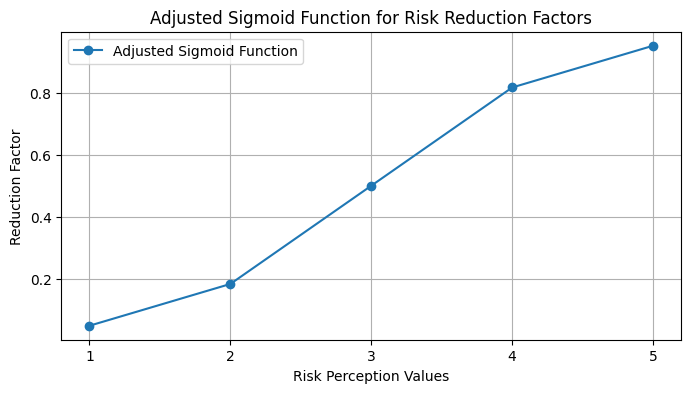

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Updated sigmoid function with adjusted steepness and midpoint
def sigmoid(x):
    return 1 / (1 + np.exp(-1.5 * (x - 3)))  # Increased steepness and adjusted midpoint

# Applying the updated sigmoid function to the risk perception values
x_values = np.array([1, 2, 3, 4, 5])
y_values = sigmoid(x_values)

# Plotting the updated sigmoid function
plt.figure(figsize=(8, 4))
plt.plot(x_values, y_values, 'o-', label='Adjusted Sigmoid Function')
plt.xlabel('Risk Perception Values')
plt.ylabel('Reduction Factor')
plt.title('Adjusted Sigmoid Function for Risk Reduction Factors')
plt.xticks(x_values)
plt.grid(True)
plt.legend()
plt.show()


In [13]:
pop

,id,age,gender,employed,higher_education,home_x,home_y,Secondary_start,Secondary_dur,Work_start,Work_dur,Education_start,Education_dur,work_id,work_x,work_y,homeid,age_category
0,5423803,40-44,0.0,0,17.0,999875,197404,186,0,132,46,118,46,123131,982122,206105,466221,41-65
1,6396469,80-84,1.0,0,17.0,998148,181317,150,3,87,96,151,88,215279,1011470,193103,545703,66-100
2,7199312,45-49,1.0,0,17.0,1000871,156605,208,16,113,67,92,78,40452,989247,216356,610130,41-65
3,6623002,85+,0.0,0,17.0,984635,156479,198,16,165,99,153,44,253813,1058149,221117,564857,66-100
4,1823525,50-54,1.0,1,17.0,1004466,214938,121,50,132,67,120,72,611732,990943,204612,170176,41-65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399240,7422661,50-54,1.0,1,17.0,997975,176848,145,3,94,98,102,93,294497,1016515,257342,627087,41-65
1399241,7215379,40-44,0.0,1,17.0,999721,155155,232,33,105,93,197,52,70901,983148,213779,611171,41-65
1399242,5049638,45-49,1.0,0,17.0,1020028,252077,106,0,148,95,221,88,341036,1049724,154769,437497,41-65
1399243,6079912,85+,0.0,1,17.0,989202,183114,140,18,219,1,126,47,8909,989292,211735,519407,66-100


In [11]:
((pop['Secondary_dur']-population_df['Secondary_dur'])/pop['Secondary_dur'])

0               NaN
1          0.333333
2          0.125000
3          0.312500
4          0.200000
             ...   
1399240    0.333333
1399241    0.060606
1399242         NaN
1399243    0.166667
1399244    0.125000
Name: Secondary_dur, Length: 1399245, dtype: float64

Create 2 other files for 10m preferences

In [ ]:
col = ['earliest_start','latest_start','max_duration','min_duration']
for c in col:
    activity_local_filt_sampled[c] = round(activity_local_filt_sampled[c]*2)

activity_local_filt_sampled[col] = activity_local_filt_sampled[col].astype(int) 
# activity_local_filt_sampled.drop(['start_time', 'end_time'], axis=1).to_csv(f'Data/2_PreProcessed/activity_10m.csv', index=False)

# for activity_type in activity_types:
#     population_local_sample[f'{activity_type}_start'] = round(population_local_sample[f'{activity_type}_start']/2)
#     population_local_sample[f'{activity_type}_dur'] = round(population_local_sample[f'{activity_type}_dur']/2)

# int_columns_2 = ['home_x', 'home_y', 'work_x', 'work_y', 'work_id', 'work_start', 'shop_start', 'leisure_start', 'education_start',
#                  'work_dur', 'shop_dur', 'leisure_dur', 'education_dur'] 
# population_local_sample[int_columns_2] = population_local_sample[int_columns_2].astype(int) 
# population_local_sample.to_csv(f'Data/2_PreProcessed/population_10m.csv', index=False) 

# Exploration

In [ ]:
# Drop rows where any of the required columns have NaNs
population_local_sample.dropna(subset=['home_x', 'home_y', 'work_x', 'work_y'], inplace=True)

# Now apply the distance calculation
population_local_sample['distance_H2W'] = np.sqrt(
    (population_local_sample['home_x'] - population_local_sample['work_x'])**2 +
    (population_local_sample['home_y'] - population_local_sample['work_y'])**2
)
population_local_sample['distance_H2W'].mean()

In [ ]:
import matplotlib.pyplot as plt
# Plot the distribution of distance
plt.figure(figsize=(10, 6))
plt.hist(population_local_sample['distance_H2W'], bins=30, alpha=0.7, color='blue')
plt.title('OURS Distribution of Distance from Home to Work')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot the boxplot of the distance
plt.figure(figsize=(10, 2))
plt.boxplot(population_local_sample['distance_H2W'].dropna(), vert=False)  # Drop NA values for boxplot
plt.title('Boxplot of Distance from Home to Work')
plt.xlabel('Distance')
plt.grid(True)
plt.show()

In [ ]:
merged = df_work_facilities.merge(population_local, how='left', on='id')
# merged.head()

In [ ]:
# Drop rows where any of the required columns have NaNs
merged.dropna(subset=['home_x', 'home_y', 'x', 'y'], inplace=True)

# Now apply the distance calculation
merged['distance_H2W'] = np.sqrt(
    (merged['home_x'] - merged['x'])**2 +
    (merged['home_y'] - merged['y'])**2
)
merged['distance_H2W'].mean()

In [ ]:
# Plot the distribution of distance
plt.figure(figsize=(10, 6))
plt.hist(merged['distance_H2W'], bins=100, alpha=0.7, color='blue')
plt.title('REAL Distribution of Distance from Home to Work')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.xlim((0, 50000))
plt.grid(True)
plt.show()

# Plot the boxplot of the distance
plt.figure(figsize=(10, 2))
plt.boxplot(merged['distance_H2W'].dropna(), vert=False)  # Drop NA values for boxplot
plt.title('Boxplot of Distance from Home to Work')
plt.xlabel('Distance')
plt.xlim((0, 50000))
plt.grid(True)
plt.show()

In [ ]:
a['facility'].nunique()

In [ ]:
b=pd.read_csv('/Users/cloecortesbalcells/GitHub/Modeling-Individual-Activity-Schedules-and-Behavior-Changes-in-COVID-19/Data/1_Original/vaud_activities.csv.gz')

In [ ]:
a['id'].nunique()

In [ ]:
b['facility'][b['type']=='leisure'].nunique()

In [ ]:
15510+70697

In [ ]:
a['group'].unique()

In [ ]:
85000